In [2]:
# Part 1: Import libraries and dataset

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Adjust pandas display options
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.expand_frame_repr', False)  # Prevent truncation

# Import data
df = pd.read_csv('/Users/joezhou/Downloads/Mentum Assignment Data/Customer-churn-records.csv',sep=",")

In [14]:

# Part 2: Data Preprocessing

# In this section, we perform preprocessing steps on the dataset to prepare it for modeling. This includes feature engineering, encoding categorical variables, and splitting the data into training and testing sets.

## 1. Feature Engineering

### 1.1. Create a New Feature for $0 Balances
# We create a new binary feature to capture accounts with a balance of $0. This feature is useful for identifying potentially inactive accounts.

# python
# Create a new feature to capture $0 balances based on findings from Assignment 1
df['Flag_Null_Balance'] = df['Balance'].apply(lambda x: 1 if x == 0 else 0)

# 2. Encoding Categorical Variables

# 2.1. One-Hot Encoding
# We use one-hot encoding to convert categorical variables into a format suitable for machine learning algorithms. The drop_first=False parameter ensures that we retain all dummy variables.

# Apply one-hot encoding to categorical variables
df_encoded = pd.get_dummies(df, columns=['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'Card Type'], drop_first=False)

# 2.2. Convert Boolean Columns to Integers
# Boolean columns are converted to integers to ensure compatibility with machine learning models.

# Identify and convert boolean columns to integers
bool_columns = df_encoded.select_dtypes(include='bool').columns
df_encoded[bool_columns] = df_encoded[bool_columns].astype(int)

# 2.3. Drop Redundant Binary Variables
# To reduce noise in the data, we drop some binary encoded variables that are redundant.

# Drop some encoded variables that are binary in nature
df_encoded.drop(columns=['HasCrCard_0', 'IsActiveMember_0'], inplace=True)


#============================================================================================
# Create feature engineered variables following round #1 of predictive model development
#============================================================================================

#create new variable to assess the utility impact of loan balance and estimated salary
df_encoded['CALC_BAL_eSAL_RATE'] = df_encoded['Balance'] / df_encoded['EstimatedSalary']

#create new variable to the ratio of points earned and salary, the underlying assumption of customers with more points and salary are more interest rate sensitive
df_encoded['CALC_PTS_eSAL_RATE'] = df_encoded['Point Earned'] / df_encoded['EstimatedSalary']



# 3. Feature Selection

# 3.1. Select Features and Target Variable
# We select the relevant features and target variable for our model. The 'complain' variable is intentionally omitted due to its high correlation with the 'Exited' variable, which could lead to overfitting.

# Define features (X) and target variable (y)
X = df_encoded[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 
                'EstimatedSalary', 'Satisfaction Score', 'Point Earned',
                'Flag_Null_Balance', 'Geography_NSW', 'Geography_QLD', 'Geography_VIC', 
                'HasCrCard_1', 'IsActiveMember_1', 
                'Card Type_DIAMOND', 'Card Type_GOLD', 'Card Type_PLATINUM', 
                'Card Type_SILVER',
                #new featured engineered variables
                'CALC_BAL_eSAL_RATE','CALC_PTS_eSAL_RATE'
                #remove the following variables due to potential bias
                # 'Gender_Female', 'Gender_Male'
                ]]

y = df_encoded['Exited']


# 4. Data Splitting

# 4.1. Split the Data into Training and Testing Sets
# We split the data into training and testing sets to evaluate the performance of our model.

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [15]:
# Part 3: Build Models

# Standardizing the data
# Standardization rescales features to have a mean of 0 and a standard deviation of 1,
# which is essential for models sensitive to the scale of input data (e.g., Logistic Regression).
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit to the training data and transform it
X_test_scaled = scaler.transform(X_test)  # Transform the test data using the same scaling parameters

# Logistic Regression
# Create an instance of the Logistic Regression model
log_reg = LogisticRegression()
# Fit the model to the scaled training data and corresponding labels
log_reg.fit(X_train_scaled, y_train)
# Predict the labels for the scaled test data
y_pred_logreg = log_reg.predict(X_test_scaled)

# Decision Tree Classifier
# Create an instance of the Decision Tree Classifier with a fixed random state for reproducibility
tree_clf = DecisionTreeClassifier(random_state=42)
# Fit the model to the original training data
tree_clf.fit(X_train, y_train)
# Predict the labels for the test data
y_pred_tree = tree_clf.predict(X_test)

# Random Forest Classifier
# Create an instance of the Random Forest Classifier with a fixed random state for reproducibility
rf_clf = RandomForestClassifier(random_state=42)
# Fit the model to the original training data
rf_clf.fit(X_train, y_train)
# Predict the labels for the test data
y_pred_rf = rf_clf.predict(X_test)

# Gradient Boosting Classifier
# Create an instance of the Gradient Boosting Classifier with a fixed random state for reproducibility
gb_clf = GradientBoostingClassifier(random_state=42)
# Fit the model to the original training data
gb_clf.fit(X_train, y_train)
# Predict the labels for the test data
y_pred_gb = gb_clf.predict(X_test)

In [16]:
# Part 4: Evaluate Models

# Model Evaluation Function
def evaluate_model(y_test, y_pred, model_name):
    """
    Evaluates and prints the performance metrics for a given model.
    
    Parameters:
    - y_test: Actual labels from the test set
    - y_pred: Predicted labels from the model
    - model_name: Name of the model being evaluated (for display purposes)
    """
    print(f"---{model_name}---")  # Print the model name for clarity
    print("Accuracy:", accuracy_score(y_test, y_pred))  # Calculate and print accuracy
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))  # Print confusion matrix
    print("Classification Report:\n", classification_report(y_test, y_pred))  # Print detailed metrics

# Evaluate models
# Call the evaluate_model function for each model with their respective predictions
evaluate_model(y_test, y_pred_logreg, "Logistic Regression")  # Evaluate Logistic Regression model
evaluate_model(y_test, y_pred_tree, "Decision Tree")          # Evaluate Decision Tree model
evaluate_model(y_test, y_pred_rf, "Random Forest")            # Evaluate Random Forest model
evaluate_model(y_test, y_pred_gb, "Gradient Boosting")        # Evaluate Gradient Boosting model

---Logistic Regression---
Accuracy: 0.8173333333333334
Confusion Matrix:
 [[2337   79]
 [ 469  115]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.97      0.90      2416
           1       0.59      0.20      0.30       584

    accuracy                           0.82      3000
   macro avg       0.71      0.58      0.60      3000
weighted avg       0.79      0.82      0.78      3000

---Decision Tree---
Accuracy: 0.7866666666666666
Confusion Matrix:
 [[2060  356]
 [ 284  300]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.85      0.87      2416
           1       0.46      0.51      0.48       584

    accuracy                           0.79      3000
   macro avg       0.67      0.68      0.67      3000
weighted avg       0.80      0.79      0.79      3000

---Random Forest---
Accuracy: 0.8686666666666667
Confusion Matrix:
 [[2345   71]
 [ 323  261]]
Classif

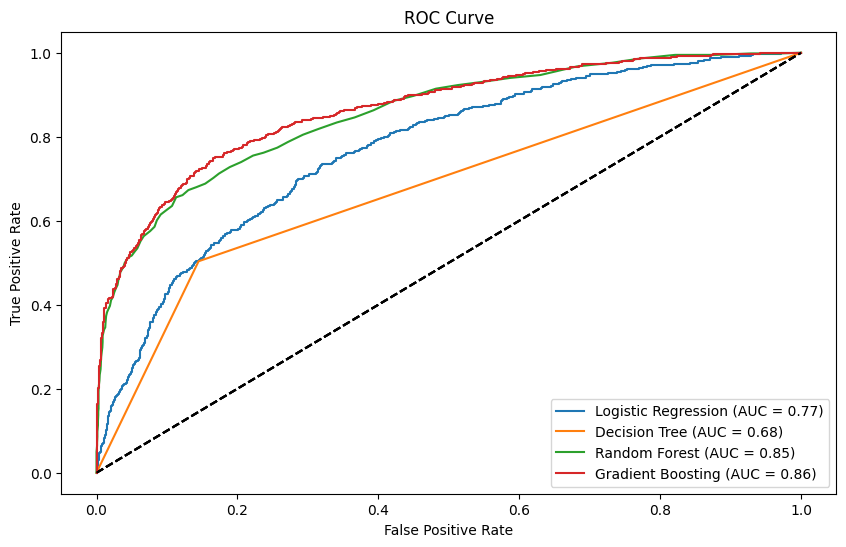

In [8]:
# Part 4.1: use ROC curve to demonstrate the best model

# Function to plot ROC curve
def plot_roc_curve(y_test, y_pred_prob, model_name):
    """
    Plots the ROC curve for a specified model.
    
    Parameters:
    - y_test: Actual labels from the test set
    - y_pred_prob: Predicted probabilities from the model
    - model_name: Name of the model being evaluated (for display purposes)
    """
    # Compute the false positive rate (fpr) and true positive rate (tpr)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])
    # Calculate the area under the ROC curve (AUC)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')  # Plot model's ROC curve
    plt.plot([0, 1], [0, 1], 'k--')  # Plot the diagonal line representing random chance
    plt.xlabel('False Positive Rate')  # Label for x-axis
    plt.ylabel('True Positive Rate')  # Label for y-axis
    plt.title('ROC Curve')  # Title of the plot
    plt.legend()  # Show legend

# Create a figure for plotting
plt.figure(figsize=(10, 6))

# Call the plot_roc_curve function for each model using predicted probabilities
plot_roc_curve(y_test, log_reg.predict_proba(X_test_scaled), 'Logistic Regression')  # ROC for Logistic Regression
plot_roc_curve(y_test, tree_clf.predict_proba(X_test), 'Decision Tree')              # ROC for Decision Tree
plot_roc_curve(y_test, rf_clf.predict_proba(X_test), 'Random Forest')                # ROC for Random Forest
plot_roc_curve(y_test, gb_clf.predict_proba(X_test), 'Gradient Boosting')            # ROC for Gradient Boosting

# Display the ROC curve for all models
plt.show()

/var/folders/0h/0f26ts797zn_y1qfqv62wxg40000gn/T/ipykernel_27558/2364034579.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(value, index, f'{coef_importance_sorted[index]:.2f}', va='center', ha='right', color='black')


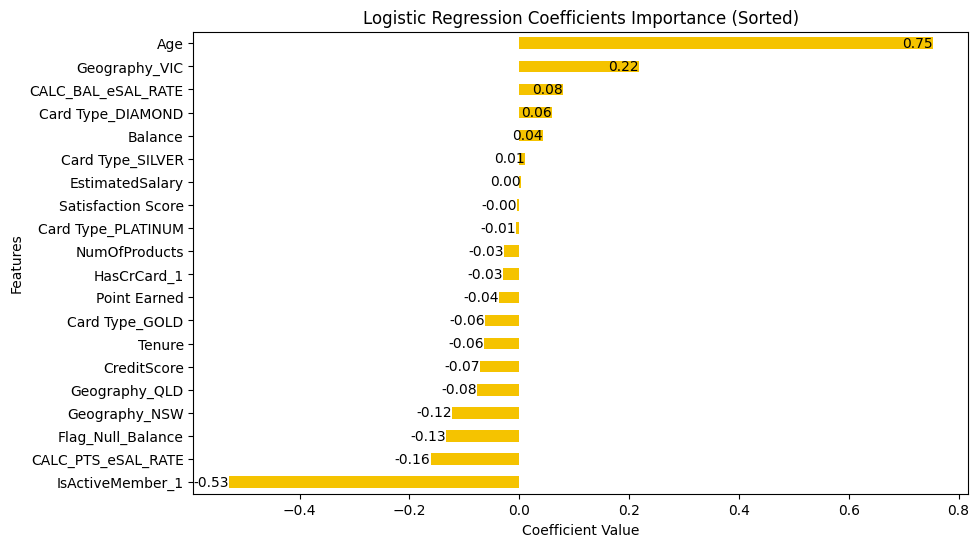

In [17]:
# Part 5.1: understanding key drivers, using logistic regression 

# Plot Logistic Regression Coefficients (Sorted by Importance)
# Extract the coefficients from the fitted logistic regression model
coef_importance = pd.Series(log_reg.coef_[0], index=X.columns)  # Create a Series with feature names as index
# Sort the coefficients by their absolute values to identify important features
coef_importance_sorted = coef_importance.sort_values(ascending=False)  # Sort by importance

# Create a horizontal bar plot for visualizing coefficient importance
plt.figure(figsize=(10, 6))  # Set the size of the plot
coef_importance_sorted.plot(kind='barh', color='#F5C300')  # Create a horizontal bar plot with a specified color

# Annotate each bar with the actual coefficient value
for index, value in enumerate(coef_importance_sorted):
    # Display the coefficient value on the right side of each bar
    plt.text(value, index, f'{coef_importance_sorted[index]:.2f}', va='center', ha='right', color='black')

# Set the title and labels for the plot
plt.title('Logistic Regression Coefficients Importance (Sorted)')  # Title of the plot
plt.xlabel('Coefficient Value')  # Label for x-axis
plt.ylabel('Features')  # Label for y-axis
plt.gca().invert_yaxis()  # Invert y-axis to display the most important feature at the top
plt.show()  # Display the plot

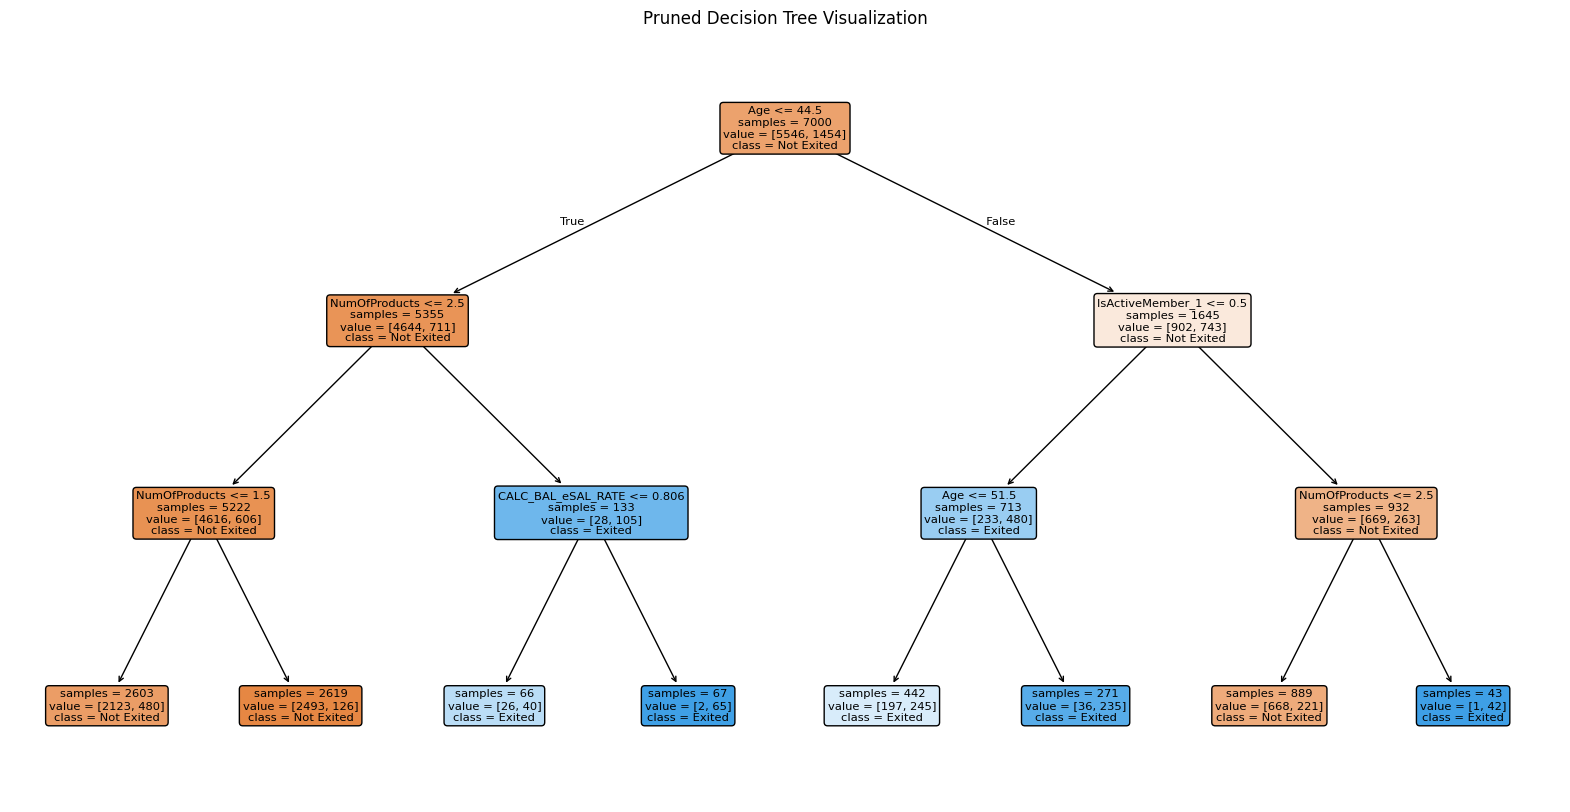

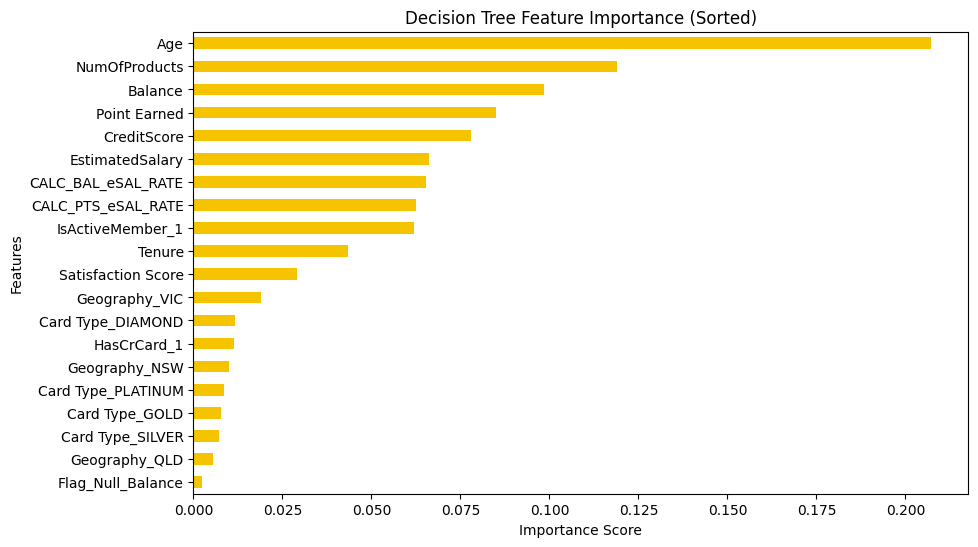


Decision Tree Feature Importance (Sorted):
Age                   0.207334
NumOfProducts         0.119025
Balance               0.098385
Point Earned          0.084861
CreditScore           0.077941
EstimatedSalary       0.066291
CALC_BAL_eSAL_RATE    0.065415
CALC_PTS_eSAL_RATE    0.062453
IsActiveMember_1      0.061974
Tenure                0.043295
Satisfaction Score    0.029080
Geography_VIC         0.018992
Card Type_DIAMOND     0.011780
HasCrCard_1           0.011448
Geography_NSW         0.010108
Card Type_PLATINUM    0.008603
Card Type_GOLD        0.007831
Card Type_SILVER      0.007189
Geography_QLD         0.005633
Flag_Null_Balance     0.002363
dtype: float64


In [18]:
# Part 5.2: understanding key drivers, using decision tree

# Set a max_depth to prune the tree and avoid overfitting
# You can adjust the max_depth based on your preferences
pruned_tree_clf = DecisionTreeClassifier(random_state=42, max_depth=3)  # Limit the tree depth
pruned_tree_clf.fit(X_train, y_train)


# Plot the pruned Decision Tree
plt.figure(figsize=(20,10))

plot_tree(pruned_tree_clf, 
          feature_names=X.columns, 
          filled=True, 
          rounded=True, 
          class_names=['Not Exited', 'Exited'],
          proportion=False, 
          impurity=False,
          node_ids=False
          )

plt.title("Pruned Decision Tree Visualization")
plt.show()


# Feature Importance from Decision Tree
tree_importance = pd.Series(tree_clf.feature_importances_, index=X.columns)
tree_importance_sorted = tree_importance.sort_values(ascending=False)

# Plot Decision Tree Feature Importance
plt.figure(figsize=(10,6))
tree_importance_sorted.plot(kind='barh', color='#F5C300')
plt.title('Decision Tree Feature Importance (Sorted)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.show()


# Print the feature importance
print("\nDecision Tree Feature Importance (Sorted):")
print(tree_importance_sorted)


In [23]:
#Perform Hypertunning for gradient boosting classifer model due to predictive power compared to other comparative model types.

import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from scipy.stats import randint, uniform


# Initialize the Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier()

# Define the hyperparameter grid for RandomizedSearchCV
# This grid contains ranges of hyperparameters to sample from during the tuning process
param_distributions = {
    'n_estimators': randint(50, 300),  # Number of boosting stages to be run
    'learning_rate': uniform(0.01, 0.3),  # Step size shrinking to prevent overfitting
    'max_depth': randint(1, 10),  # Maximum depth of the individual estimators
    'min_samples_split': randint(2, 10),  # Minimum number of samples required to split an internal node
    'min_samples_leaf': randint(1, 10),  # Minimum number of samples required to be at a leaf node
}

# Set up the RandomizedSearchCV
# This will perform the hyperparameter search with cross-validation
random_search = RandomizedSearchCV(
    gb_classifier,
    param_distributions,
    n_iter=10,  # Number of parameter settings sampled
    scoring='accuracy',  # Metric to evaluate the model
    cv=3,  # Number of cross-validation folds
    verbose=1,  # Verbosity level
    n_jobs=-1,  # Use all available cores for parallel processing
    random_state=42  # Ensure reproducibility of results
)

# Fit the model to the training data using the randomized search
random_search.fit(X_train, y_train)

# Output the best hyperparameters found during the search
print("Best parameters found: ", random_search.best_params_)

# Make predictions on the test set using the best model
y_pred = random_search.predict(X_test)

# Evaluate the model's performance
print("Accuracy: ", accuracy_score(y_test, y_pred))  # Print the accuracy of the model
print(classification_report(y_test, y_pred))  # Print a detailed classification report


Fitting 3 folds for each of 10 candidates, totalling 30 fits


Best parameters found:  {'learning_rate': np.float64(0.1451497755908629), 'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 109}
Accuracy:  0.8706666666666667
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2416
           1       0.78      0.47      0.59       584

    accuracy                           0.87      3000
   macro avg       0.83      0.72      0.75      3000
weighted avg       0.86      0.87      0.86      3000

